In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import models.resnet as resnet

2024-09-04 18:37:19.179434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 18:37:19.668460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-04 18:37:19.668514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-04 18:37:19.668520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# load data
# load the data
import sys
import numpy as np

thismodule = sys.modules[__name__]

with np.load('extrernal_test_data_beats.npz') as data:
    for key in data:
        setattr(thismodule, key, data[key])

print(all_beats.shape)
print(all_labels.shape)
print(all_source.shape)

(1103, 100, 12)
(1103,)
(1103,)


In [6]:
X_input = keras.Input(shape=all_beats.shape[1:])
num_classes = 1
model, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
uninit_wights = model.get_weights()
model.load_weights('model-weights/fine-tuned/resnet10_smote_transfer_rbbb_freeze8.h5')
init_weights = model.get_weights()

# confrim the weights are loaded
for i in range(len(uninit_wights)):
    if np.array_equal(uninit_wights[i], init_weights[i]):
        print("Weights not loaded correctly")

In [7]:
# evaluate the model
loss, acc = model.evaluate(all_beats, all_labels, verbose=2)
print("Unseen data, accuracy: {:5.2f}%".format(100*acc))

# bard only
bard = all_source == 1
loss, acc = model.evaluate(all_beats[bard], all_labels[bard], verbose=2)
print("Bard, accuracy: {:5.2f}%".format(100*acc))

# uhf only
uhf = all_source == 0
loss, acc = model.evaluate(all_beats[uhf], all_labels[uhf], verbose=2)
print("UHF, accuracy: {:5.2f}%".format(100*acc))


35/35 - 1s - loss: 1.8240 - accuracy: 0.5340 - 625ms/epoch - 18ms/step
Unseen data, accuracy: 53.40%
23/23 - 0s - loss: 2.0284 - accuracy: 0.5191 - 77ms/epoch - 3ms/step
Bard, accuracy: 51.91%
12/12 - 0s - loss: 1.4173 - accuracy: 0.5637 - 44ms/epoch - 4ms/step
UHF, accuracy: 56.37%


In [5]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


In [9]:
# eval
loss, acc = model.evaluate(X_test, Y_test, verbose=2)
print("China, accuracy: {:5.2f}%".format(100*acc))


68/68 - 1s - loss: 0.1357 - accuracy: 0.9736 - 613ms/epoch - 9ms/step
China, accuracy: 97.36%


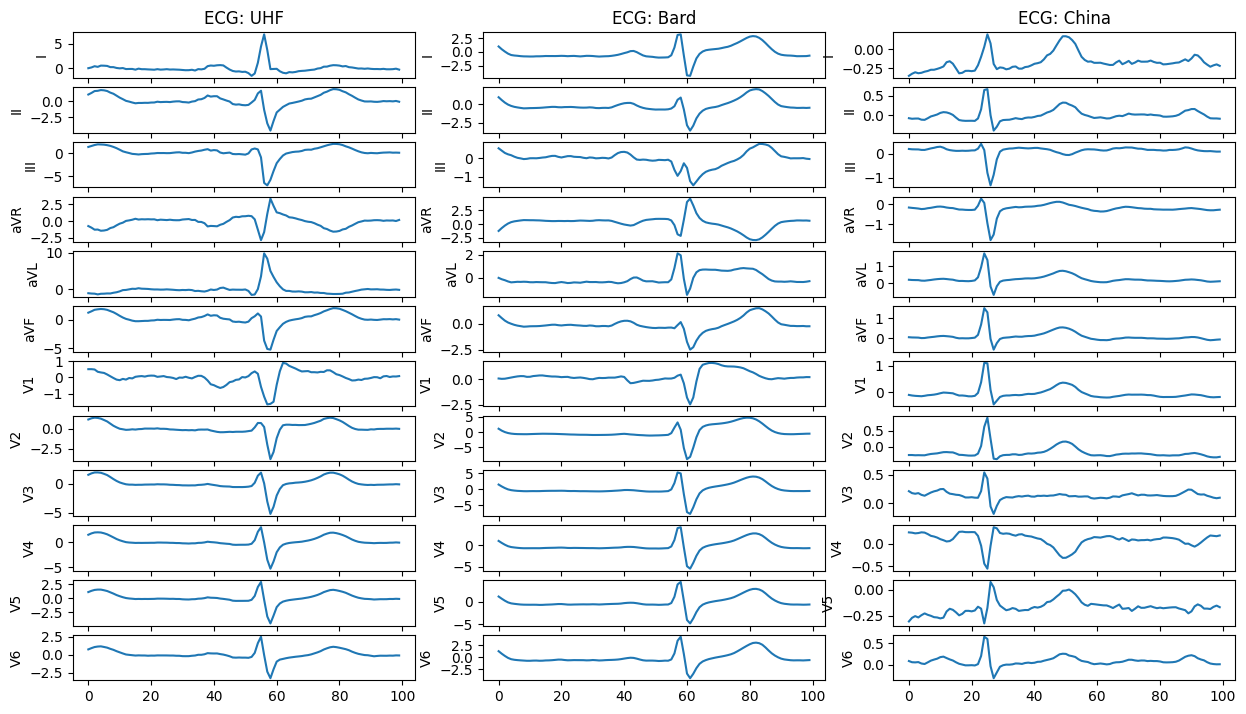

In [11]:
import data_visualisation as dv

# get a uhf beat
uhf = all_source == 0
uhf_beat = all_beats[uhf][0]

# get a bard beat
bard = all_source == 1
bard_beat = all_beats[bard][0]

# get a china beat
china_beat = X_test[1]

dv.plot_12_lead_ecgs([uhf_beat, bard_beat, china_beat], ['UHF', 'Bard', 'China'])